# Task Overview

Your task will be to implement a variant of *ProxyProp* (Proximal Backpropagation) – a modification of backpropagation in which the weights of the network are not updated according to gradient descent, but according to [proximal mapping operator](https://en.wikipedia.org/wiki/Proximal_operator). This proximal operator in many cases results in a descent that is quicker than in the case of traditional gradient descent. Interestingly enough, the proximal operator arose in the context of gradient descent in which the minimized function is not differentiable, and gradient descent cannot be applied directly as we cannot compute the Jacobi matrix. This method is called [proximal gradient method](https://en.wikipedia.org/wiki/Proximal_gradient_method). However, we are interested here in the efficiency of the approach rather than its robustness. The backpropagation method in the proximal approach (i.e. *ProxyProp* algorithm) is described in detail in [this paper](https://arxiv.org/pdf/1706.04638v3).

The original algorithm presented in the paper uses purely linear transformations between subsequent network layers. Part of your task is to use affine transformations there, i.e. ones with biases.

You should use an MLP architecture trained on the MNIST dataset. You should implement the network in numpy.

Tasks:
1. (9pt) Fill missing code below
  - 1pt implement the `__init__` method
  - 2pt implement the feedforward method
  - 6pt implement the backpropagation
2. Train the models (find proper hyperparameters). Visualize the learning speed of your best model compared with the standard backpropagation (plot training loss for subsequent numbers of epochs using both algorithms). Your model should reach at least 94% accuracy. Use ClearML to log your scores. Make a comparison of memory usage for _ProxProp_ network and the network you implemented in lab 3.
  - 1pt for accuracy above 94%
  - 1pt for initialization of the standard backpropagation and ProxyProp with the same random values
  - 1pt for visualizations (we recommend downloading plots from clear ml)
  - 2pt if [clear ml](https://clear.ml/docs/latest/docs/) used properly
  - 1pt for comparing memory usage.

Part of the assignment consists of deriving proper formulas for a proposed slight modification of _ProxProp_. We do not grant points separately for this activity. You are rewarded for that only after proper implementation.


## Potential questions, clarifications
- Q: Can I modify code of _ProxyProp_ outside #Your code goes here # to include logging?
  - Yes, in ProxyProp.SGD
- Q: Can I modify the code of _Network_ to include logging?
  - Yes.

In [9]:
%pip install clearml
%pip install memory-profiler
%pip install torchvision

Note: you may need to restart the kernel to use updated packages.

Note: you may need to restart the kernel to use updated packages.


In [10]:
import numpy as np
from clearml import Logger
from typing import List
from numpy.linalg import inv


In [11]:
# %load_ext memory_profiler
from memory_profiler import memory_usage

# Dataset loading


In [12]:
!wget -O mnist.npz https://s3.amazonaws.com/img-datasets/mnist.npz

'wget' is not recognized as an internal or external command,
operable program or batch file.


In [13]:
def load_mnist(path: str = "mnist.npz"):
    with np.load(path) as f:
        x_train, _y_train = f["x_train"], f["y_train"]
        x_test, _y_test = f["x_test"], f["y_test"]

    x_train = x_train.reshape(-1, 28 * 28) / 255.0
    x_test = x_test.reshape(-1, 28 * 28) / 255.0

    y_train = np.zeros((_y_train.shape[0], 10))
    y_train[np.arange(_y_train.shape[0]), _y_train] = 1

    y_test = np.zeros((_y_test.shape[0], 10))
    y_test[np.arange(_y_test.shape[0]), _y_test] = 1

    return (x_train, y_train), (x_test, y_test)


(x_train, y_train), (x_test, y_test) = load_mnist()

# Set up clear ml

In [ ]:
### Your code goes here ###

from clearml import Task

web_server = 'https://app.clear.ml'
api_server = 'https://api.clear.ml'
files_server = 'https://files.clear.ml'
# I believe i was supposed tp remove the keys so i did
access_key = "..."
secret_key = "..."

Task.set_credentials(web_host=web_server,
                     api_host=api_server,
                     files_host=files_server,
                     key=access_key,
                     secret=secret_key)

###########################

# A quick recap of the backpropagation model

## Forward pass

We begin with $g^{(0)} = x$.

To apply forward pass, use the following formulas L times:

$$
%\begin{equation}
f^{(l + 1)} = W^{(l+1)} g^{(l)} + b^{(l+1)}
\nonumber
%\end{equation}
$$
$$
%\begin{equation}
g^{(l)} = \sigma(f^{(l)})
\nonumber
%\end{equation}
%\\
$$

$l = 1, 2, \ldots, L$.


Then, use output of the network is $g^{(L)}$ to compute the loss $L(y, g^{(L)})$.

## Backward pass

We begin with $\frac{\partial L}{\partial g^{(L)}}$, which can be computed directly.

To compute gradients, use the following formulas:

$$
%\begin{equation}
\frac{\partial L}{\partial f^{(l)}} = \frac{\partial L}{\partial g^{(l)}} \odot g^{(l)} \odot (1 - g^{(l)})
\nonumber
%\end{equation}
$$
$$
%\begin{equation}
\frac{\partial L}{\partial g^{(l)}} = (W^{(l+1)})^{T} \cdot \frac{\partial L}{\partial f^{(l+1)}}
\nonumber
%\end{equation}
$$
$$
%\begin{equation}
\frac{\partial L}{\partial b^{(l)}} = \frac{\partial L}{\partial f^{(l)}}
\nonumber
%\end{equation}
$$
$$
%\begin{equation}
\frac{\partial L}{\partial W^{(l)}} = \frac{\partial L}{\partial f^{(l)}} \cdot g^{(l-1)}
\nonumber
%\end{equation}
$$

$l = L, L-1, \ldots, 1$.

# Network definition (as in laboratory 3)


In [15]:
def sigmoid(z: np.ndarray) -> float:
    return 1.0 / (1.0 + np.exp(-z))

def sigmoid_prime(z: np.ndarray) -> float:
    return sigmoid(z) * (1 - sigmoid(z))


def logloss(
    x: np.ndarray,
    y: np.ndarray,
) -> float:
    return -(np.log(x) * y).sum() / y.shape[1]

In [16]:
class Network(object):
    def __init__(
        self,
        sizes: List[int],
    ) -> None:
        # initialize biases and weights with random normal distr.
        # weights are indexed by target node first
        self.num_layers = len(sizes)
        self.sizes = sizes
        self.biases = [np.random.randn(y, 1) for y in sizes[1:]]
        self.weights = [np.random.randn(y, x) for x, y in zip(sizes[:-1], sizes[1:])]

    def feedforward(
        self,
        a: np.ndarray,
    ) -> np.ndarray:
        # Run the network on a batch
        a = a.T
        for b, w in zip(self.biases, self.weights):
            a = sigmoid(np.matmul(w, a) + b)
        return a

    def update_mini_batch(
        self,
        mini_batch: tuple[np.ndarray, np.ndarray],
        eta: float,
    ):
        # Update networks weights and biases by applying a single step
        # of gradient descent using backpropagation to compute the gradient.
        # The gradient is computed for a mini_batch which is as in tensorflow API.
        # eta is the learning rate
        nabla_b, nabla_w, loss = self.backprop(mini_batch[0].T, mini_batch[1].T)

        self.weights = [
            w - (eta / len(mini_batch[0])) * nw for w, nw in zip(self.weights, nabla_w)
        ]
        self.biases = [
            b - (eta / len(mini_batch[0])) * nb for b, nb in zip(self.biases, nabla_b)
        ]
        return loss

    def backprop(
        self,
        x: np.ndarray,
        y: np.ndarray,
    ) -> tuple[np.ndarray, np.ndarray, float]:
        # For a single input (x,y) return a pair of lists.
        # First contains gradients over biases, second over weights.
        g = x
        gs = [g]  # list to store all the gs, layer by layer
        fs = []  # list to store all the fs, layer by layer
        for b, w in zip(self.biases, self.weights):
            f = np.dot(w, g) + b
            fs.append(f)
            g = sigmoid(f)
            gs.append(g)
        # backward pass <- both steps at once
        loss = logloss(gs[-1], y)
        dLdg = self.cost_derivative(gs[-1], y)
        dLdfs = []
        for w, g in reversed(list(zip(self.weights, gs[1:]))):
            dLdf = np.multiply(dLdg, np.multiply(g, 1 - g))
            dLdfs.append(dLdf)
            dLdg = np.matmul(w.T, dLdf)

        dLdWs = [np.matmul(dLdf, g.T) for dLdf, g in zip(reversed(dLdfs), gs[:-1])]
        dLdBs = [
            np.sum(dLdf, axis=1).reshape(dLdf.shape[0], 1) for dLdf in reversed(dLdfs)
        ]
        return (dLdBs, dLdWs, loss)

    def evaluate(
        self,
        test_data: tuple[np.ndarray, np.ndarray],
    ) -> float:
        # Count the number of correct answers for test_data
        pred = np.argmax(self.feedforward(test_data[0]), axis=0)
        corr = np.argmax(test_data[1], axis=1).T
        return np.mean(pred == corr)

    def cost_derivative(
        self,
        output_activations: np.ndarray,
        y: np.ndarray,
    ) -> np.ndarray:
        return output_activations - y

    def SGD(
        self,
        training_data: np.ndarray,
        epochs: int,
        mini_batch_size: int,
        eta: float,
        test_data: np.ndarray = None,
        logger: Logger = None,
    ) -> None:
        x_train, y_train = training_data
        if test_data:
            x_test, y_test = test_data
        for j in range(epochs):
            loss = 0
            for i in range(x_train.shape[0] // mini_batch_size):
                x_mini_batch = x_train[
                    (mini_batch_size * i) : (mini_batch_size * (i + 1))
                ]
                y_mini_batch = y_train[
                    (mini_batch_size * i) : (mini_batch_size * (i + 1))
                ]
                loss += self.update_mini_batch((x_mini_batch, y_mini_batch), eta)
            wloss = loss / (x_train.shape[0] // mini_batch_size)
            if test_data:
                acc = self.evaluate((x_test, y_test))
                print("Epoch: {0}, Accuracy: {1}, Loss: {2}".format(j, acc, wloss))
            else:
                print("Epoch: {0}".format(j))


# # Simple check if all is fine
# network = Network([784, 30, 30, 10])
# network.SGD(
#     (x_train, y_train),
#     epochs=2,
#     mini_batch_size=100,
#     eta=3.0,
#     test_data=(x_test, y_test),
# )

# The original ProxProp definition

Let us fix the notation for our network as in the following figure. We can see here a series of layers with $n_0,\ldots, n_{L-2}$ nodes. Each layer is composed of input nodes that depend linearly ($\phi$ operator) on the output nodes that depend non-linearly on the respective input nodes ($\sigma$ operator). The quality of the final output is measured by the final loss function ${\cal L}_y$ (typically $\frac{1}{2}\|\cdot\|^2$).




![image.png]( 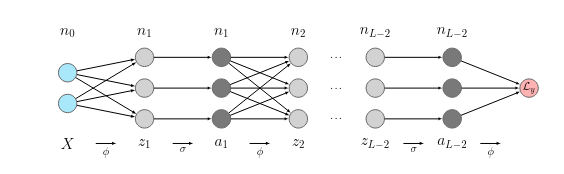)

_ProxProp_ procedure itself works similarly to a standard backpropagation procedure, as shown in the following figure.


![image.png]( 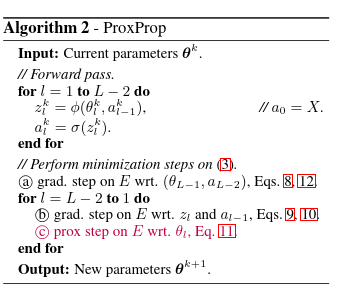)

For comparison, the standard backpropagation algorithm in this setting is as follows:


![image.png]( 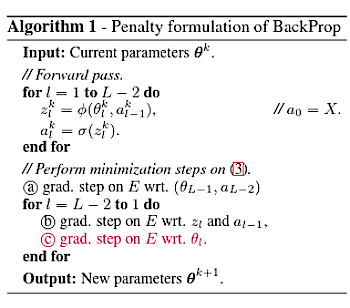)

Forward: The forward propagation phase is just as in the standard algorithm:

$z^k_l = \phi(\theta^k_l, a^k_{l−1}),$

$a^k_l = \sigma(z^k_l),$

where $\phi$ is supposed to be a linear transformation with weights $\theta^k_l$ over values $a^k_{l-1}$ and $\sigma$ is some non-linear step, e.g. the sigmoid function or the LeRU. You can use the sigmoid function for the purposes of this work.

Reverse: In the backpropagation, the step for the final layer ((a) on the figure) is exactly as in the gradient based version. In steps for the earlier layers, we recompute the z's and a's using the gradient method ((b) on the figure), but the weights are computed according to the proximal operator ((c) on the figure).

In step (a) the updated value is

$a'^{k}_{L−2} = a^k_{L−2} − \eta\nabla_{a_{L−2}} {\cal L}_y(\phi(\theta_{L−1}, a_{L−2})),$

where $\eta$ is the learning speed coefficient.

In case (b) the updated values are

$z'^{k}_l = z^k_l − \sigma'(z^k_l)(\sigma(z^k_l) − a'^k_l),$

$a'^{k}_{l−1} = a^k_{l−1} − \nabla( \frac{1}{2}\| \phi(θ^l, \cdot) − z'^k_l \|^2)(a^k_{l−1}),$

Note that the primed $a$-values are used to compute primed $z$-values and primed $z$-values are used to obtain the final value of $\theta^{k+1}$.

In case (c) the updated values are computed according to the proximal formula:

$$
\theta^{k+1}_l = \underset{\gamma}{\mathrm{argmin}} \left(\frac{1}{2} \|\phi(\gamma, a^k_{l−1}) − z'^k_l\|^2 + \frac{1}{2\tau_\theta}\|\gamma - \theta^k_l\|^2\right)
$$

The computation for the final layer is not done according to the proximity formula as it is difficult to obtain the closed formula for the necessary update, therefore it should be done according to the standard gradient descent.

The original formulas from the mentioned above paper do not use the biases. Part of the assignment is to rework this method so that the formulas include biases. You should develop a method in which biases are updated using the standard gradient descent method and the linear weight are updated using the _PropProx_ method with formulas adjusted to accommodate for biases.

# ProxProp similar to our backpropagation

Your task is to implement algorithm based on [ProxProp](https://arxiv.org/pdf/1706.04638v3). Please refer to the section above or section 4.2 in [the paper](https://arxiv.org/pdf/1706.04638v3) for algorithm description. Here we present the overview of the algorithm to be implemented.

## Forward pass

Forward pass is the same as in backpropagation implementation used in this course:
We begin with $g^{(0)} = x$.

To apply forward pass, use the following formulas L times:

$$
%\begin{equation}
f^{(l + 1)} = W^{(l+1)} g^{(l)} + b^{(l+1)}
\nonumber
%\end{equation}
$$
$$
%\begin{equation}
g^{(l)} = \sigma(f^{(l)})
\nonumber
%\end{equation}
%\\
$$

$l = 1, 2, \ldots, L$.


Then, use output of the network is $g^{(L)}$ to compute the loss $L(y, g^{(L)})$.

## Backward pass

We begin with $\frac{\partial L}{\partial g^{(L)}}$, which can be computed directly.

Gradients $\frac{\partial L}{\partial f^{(l)}}$, $\frac{\partial L}{\partial g^{(l)}}$ need to be computed.

$$
%\begin{equation}
\frac{\partial L}{\partial f^{(l)}} = \frac{\partial L}{\partial g^{(l)}} \odot g^{(l)} \odot (1 - g^{(l)})
\nonumber
%\end{equation}
$$
$$
%\begin{equation}
\frac{\partial L}{\partial g^{(l)}} = (W^{(l+1)})^{T} \cdot \frac{\partial L}{\partial f^{(l+1)}}
\nonumber
%\end{equation}
$$

For simplicity, biases will be updated as in standard backpropagation:
$$
%\begin{equation}
b^{(l)} = b^{(l)} - \eta \frac{\partial L}{\partial b^{(l)}}
\nonumber
%\end{equation}
$$
Remember to make the gradient update independent from the batch size by appropriate averaging!

Weights will be updated using values $f^{(l)}_{*}, g^{(l)}_{*}$. They are defined as follows:

$$
%\begin{equation}
g^{(L)}_{*} = g^{(L)} - \eta \frac{\partial L}{\partial g^{(L)}}
%\end{equation}
$$

$$
%\begin{equation}
f^{(l)}_{*} = f^{(l)} - \frac{\partial g^{(l)}}{\partial f^{(l)}} \cdot (g^{(l)} - g^{(l)}_{*})
%\end{equation}
$$

$l = 1, 2, \ldots, L$.

$$
%\begin{equation}
g^{(l)}_{*} = g^{(l)} - \frac{\partial f^{(l+1)}}{\partial g^{(l)}} \cdot (f^{(l+1)} - f^{(l+1)}_{*})
%\end{equation}
$$

$l = 1, 2, \ldots, L - 1$.

 The update of weights is defined as:

$$
%\begin{equation}
W^{(l)} = \text{arg min}_{W} \frac{1}{2} || W \cdot g^{(l-1)} + b^{(l)} - f^{(l)}_{*} ||^2 + \frac{1}{2\eta} || W - W^{(l)} ||^2
%\end{equation}
$$

$l = 1, 2, \ldots, L$.

Remarks:
* Weights are updated last (This means updated $b^{(l)}$ is used in the formula above).
* Please use closed form of the update assuming $W$ is a matrix. It might involve inverting some matrix. While it is not desirable in practice, the aim of this homework is to make you come up with the formula for the update :)
* Note that the original algorithm used two eta values. For the homework you should assume that these are equal and use for that only one parameter of the network.

In [ ]:
class ProxProp(object):
    def __init__(
        self,
        sizes: List[int],
        weights: np.ndarray = None,
        biases: np.ndarray = None,
    ) -> None:
        # initialize biases and weights with random normal distr.
        # weights are indexed by target node first
        # IMPORTANT: use at least one layer of size a -> a
        ### Your code goes here ###
        self.num_layers = len(sizes)
        self.sizes = sizes
        self.biases = biases or [np.random.randn(y, 1) for y in sizes[1:]]
        self.weights = weights or [np.random.randn(y, x) for x, y in zip(sizes[:-1], sizes[1:])]
        ###########################

    def feedforward(
        self,
        a: np.ndarray,
    ) -> np.ndarray:
        # Run the network
        ### Your code goes here ###
        a = a.T
        for b, w in zip(self.biases, self.weights):
            a = sigmoid(np.matmul(w, a) + b)
        return a
        ###########################

    def backprop(self, x: np.ndarray, y: np.ndarray, eta: float) -> float:
        ### Your code goes here ###
        g = x
        minibatch_size = x.shape[1]
        gs = [g]  # list to store all the gs, layer by layer
        fs = []  # list to store all the fs, layer by layer
        for b, w in zip(self.biases, self.weights):
            f = np.dot(w, g) + b
            fs.append(f)
            g = sigmoid(f)
            gs.append(g)

        # loss computed in last layer
        loss = logloss(gs[-1], y)

        # derivative of Loss over last layer
        dLdg = self.cost_derivative(gs[-1], y)

        dLdfs = []

        # first g*
        g_star = gs[-1] - eta * dLdg

        # derivatives of Loss over f and g computed using chain rule
        for w, g in reversed(list(zip(self.weights, gs[1:]))):
            dLdf = np.multiply(dLdg, np.multiply(g, 1 - g))
            dLdfs.append(dLdf)
            dLdg = np.matmul(w.T, dLdf)

        # derivative of Loss over biases
        dLdBs = [np.sum(dLdf, axis=1).reshape(dLdf.shape[0], 1) for dLdf in reversed(dLdfs)]

        # updating biases
        self.biases = [b - (eta / minibatch_size) * nb for b, nb in zip(self.biases, dLdBs)]

        # proxprop algorithm
        for i in range(1, self.num_layers):
            f_star = fs[-i] - sigmoid_prime(fs[-i]) * (gs[-i] - g_star)
            g_star = gs[-i-1] - np.matmul(self.weights[-i].T, fs[-i] - f_star)
            matrix = inv(np.dot(gs[-i-1], gs[-i-1].T) + (1 / eta) * np.identity(gs[-i-1].shape[0]))
            # adding biases to algorithm from ProxProp paper
            self.weights[-i] = (np.dot(f_star, gs[-i-1].T) - np.dot(np.tile(self.biases[-i], minibatch_size), gs[-i-1].T) + (1 / eta) * self.weights[-i]) @ matrix
            # it could be also done without np.tile: self.weights[-i] = (np.dot((f_star -self.biases[-i]), gs[-i-1].T) + (1 / eta) * self.weights[-i]) @ matrix

        return loss
        ###########################

    def evaluate(
        self,
        test_data: tuple[np.ndarray, np.ndarray],
    ) -> float:
        pred = np.argmax(self.feedforward(test_data[0]), axis=0)
        corr = np.argmax(test_data[1], axis=1).T
        return np.mean(pred == corr)

    def cost_derivative(
        self,
        output_activations: np.ndarray,
        y: np.ndarray,
    ) -> np.ndarray:
        return output_activations - y


    def SGD(
        self,
        training_data: np.ndarray,
        epochs: int,
        mini_batch_size: int,
        eta: float,
        test_data: np.ndarray = None,
        logger: Logger = None,
    ) -> None:
        x_train, y_train = training_data
        if test_data:
            x_test, y_test = test_data
        wloss = logloss(self.feedforward(x_train).T, y_train) / (
            x_train.shape[0] // mini_batch_size
        )
        for j in range(epochs + 1):
            if logger is not None:
                logger.report_scalar(
                    title="Loss", series="ProxyProp Loss", iteration=j, value=wloss
                )
            if test_data:
                acc = self.evaluate((x_test, y_test))
                if logger is not None:
                    logger.report_scalar(
                        title="Accuracy",
                        series="ProxyProp Accuracy",
                        iteration=j,
                        value=acc,
                    )
                print("Epoch: {0}, Accuracy: {1}, Loss: {2}".format(j, acc, wloss))
            else:
                print("Epoch: {0}".format(j))
            if j == epochs:
                break
            loss = 0
            for i in range(x_train.shape[0] // mini_batch_size):
                x_mini_batch = x_train[
                    (mini_batch_size * i) : (mini_batch_size * (i + 1))
                ]
                y_mini_batch = y_train[
                    (mini_batch_size * i) : (mini_batch_size * (i + 1))
                ]
                loss += self.backprop(x_mini_batch.T, y_mini_batch.T, eta)
            wloss = loss / (
                x_train.shape[0] // mini_batch_size
            )  # we compute the average of the losses over the number of minibatches


# Simple check if all is fine
network = ProxProp([784, 30, 30, 10])
network.SGD(
    (x_train, y_train),
    epochs=3,
    mini_batch_size=100,
    eta=3.0,
    test_data=(x_test, y_test),
)

Epoch: 0, Accuracy: 0.1184, Loss: 14.69231132093072
Epoch: 1, Accuracy: 0.8652, Loss: 0.7695796739659118
Epoch: 2, Accuracy: 0.9023, Loss: 0.426985892911795
Epoch: 3, Accuracy: 0.9145, Loss: 0.3453804088906372


# Train the network

Selecting random integers that will be the seed of np.random.seed for ProxProp and BackProp, so both of the networks have the same initialization values. I'm choosing 7 of them because I will train those networks for seven different eta parameters:

η ∈ \[$10^{-3}$, $10^{-2}$, $10^{-1}$, 1, $10^{1}$, $10^{2}$, $10^{3}$]

Architecture: [784, 100, 100, 10]

In [18]:
arr = np.random.randint(100, size = 7)

layers = [784, 100, 100, 10]

Check if initial weights and biases have the same values for both networks

In [19]:
np.random.seed(arr[0])
networkP = ProxProp(layers)

np.random.seed(arr[0])
networkB = Network(layers)

print(np.array_equal(networkP.weights[0],networkB.weights[0]))
print(np.array_equal(networkP.biases[0],networkB.biases[0]))

True
True


How the weights look like

In [20]:
networkP.weights[0]

array([[-0.03073927, -1.75488786,  0.98833441, ...,  0.72043739,
         0.74281639,  0.05613428],
       [-0.6269764 ,  0.67351757,  1.48743958, ...,  1.13059422,
        -1.50531524,  1.84707435],
       [ 0.46856   ,  0.21676679, -0.01372757, ..., -0.05810323,
        -1.08078503, -0.47810029],
       ...,
       [-0.89888321,  1.89072073, -1.41518459, ..., -1.0466952 ,
         0.81861225,  0.45706046],
       [ 1.26805379,  0.21271787, -1.17662309, ..., -1.7687522 ,
         0.43253425,  0.35234957],
       [-0.91713176, -0.87885242,  0.38842019, ...,  1.51481592,
         1.43177534,  0.08521495]])

Variables that will be later used to compare memory usage for ProxProp and BackProp

In [21]:
memP_usage = []
memB_usage = []

Training ProxProp:

In the beginning it looks like the ProxProp isn't learning but it's because I've chosen some extreme values for eta to see how it behaves. It reaches good accuracy for eta = 10.

In [22]:
### Your code goes here ###
for i in range(0,7):
    task = Task.create(project_name='DNN homework 1 - ProxProp', task_name=f'ProxProp {i}')
    task.mark_started()
    logger = task.get_logger()

    np.random.seed(arr[i])
    network = ProxProp(layers)
    network.SGD(
        (x_train, y_train),
        epochs=10,
        mini_batch_size=100,
        eta=10**(i-3),
        test_data=(x_test, y_test),
        logger=logger
    )
    memP_usage.append(memory_usage(-1))


    task.mark_completed()
    task.close()
###########################

Epoch: 0, Accuracy: 0.0826, Loss: 34.136236302660144
Epoch: 1, Accuracy: 0.0827, Loss: 3.4168474459341724
Epoch: 2, Accuracy: 0.0828, Loss: 3.4233612697335176
Epoch: 3, Accuracy: 0.0829, Loss: 3.4299342244550393
Epoch: 4, Accuracy: 0.0832, Loss: 3.4365669047565666
Epoch: 5, Accuracy: 0.0833, Loss: 3.443259905744749
Epoch: 6, Accuracy: 0.0832, Loss: 3.450013820350701
Epoch: 7, Accuracy: 0.0833, Loss: 3.456829236484141
Epoch: 8, Accuracy: 0.0833, Loss: 3.4637067339704792
Epoch: 9, Accuracy: 0.0835, Loss: 3.470646881278792
Epoch: 10, Accuracy: 0.0835, Loss: 3.477650232050383
Epoch: 0, Accuracy: 0.0781, Loss: 26.791233908303216
Epoch: 1, Accuracy: 0.0786, Loss: 2.689589587453503
Epoch: 2, Accuracy: 0.0793, Loss: 2.7097060301107048
Epoch: 3, Accuracy: 0.0791, Loss: 2.728245745467241
Epoch: 4, Accuracy: 0.0793, Loss: 2.744995056780587
Epoch: 5, Accuracy: 0.0791, Loss: 2.759752290441481
Epoch: 6, Accuracy: 0.0788, Loss: 2.7723577762672362
Epoch: 7, Accuracy: 0.0781, Loss: 2.7827105795068188
E

C:\Users\HP\AppData\Local\Temp\ipykernel_9616\1540929663.py:2: RuntimeWarning:

overflow encountered in exp

C:\Users\HP\AppData\Local\Temp\ipykernel_9616\1540929663.py:12: RuntimeWarning:

divide by zero encountered in log

C:\Users\HP\AppData\Local\Temp\ipykernel_9616\1540929663.py:12: RuntimeWarning:

invalid value encountered in multiply



Epoch: 1, Accuracy: 0.1035, Loss: nan
Epoch: 2, Accuracy: 0.1198, Loss: nan
Epoch: 3, Accuracy: 0.1572, Loss: nan
Epoch: 4, Accuracy: 0.1584, Loss: nan
Epoch: 5, Accuracy: 0.1758, Loss: nan
Epoch: 6, Accuracy: 0.1894, Loss: nan
Epoch: 7, Accuracy: 0.1888, Loss: nan
Epoch: 8, Accuracy: 0.2206, Loss: nan
Epoch: 9, Accuracy: 0.2166, Loss: nan
Epoch: 10, Accuracy: 0.226, Loss: nan
Epoch: 0, Accuracy: 0.1158, Loss: 36.056065286551885
Epoch: 1, Accuracy: 0.1186, Loss: nan
Epoch: 2, Accuracy: 0.1131, Loss: nan
Epoch: 3, Accuracy: 0.0975, Loss: nan
Epoch: 4, Accuracy: 0.1046, Loss: nan
Epoch: 5, Accuracy: 0.1025, Loss: nan
Epoch: 6, Accuracy: 0.1006, Loss: nan
Epoch: 7, Accuracy: 0.101, Loss: nan
Epoch: 8, Accuracy: 0.1122, Loss: nan
Epoch: 9, Accuracy: 0.1068, Loss: nan
Epoch: 10, Accuracy: 0.1111, Loss: nan


Training BackProp:

In [23]:
for i in range(0,7):
    task = Task.create(project_name='DNN homework 1 - ProxProp', task_name=f'BackProp {i}')
    task.mark_started()
    logger = task.get_logger()

    np.random.seed(arr[i])
    network = Network(layers)
    network.SGD(
        (x_train, y_train),
        epochs=10,
        mini_batch_size=100,
        eta=10**(i-3),
        test_data=(x_test, y_test),
        logger=logger
    )
    memB_usage.append(memory_usage(-1))


    task.mark_completed()
    task.close()

Epoch: 0, Accuracy: 0.0819, Loss: 3.5349096466059926
Epoch: 1, Accuracy: 0.0832, Loss: 3.8300998650674494
Epoch: 2, Accuracy: 0.0845, Loss: 4.174120314919082
Epoch: 3, Accuracy: 0.0871, Loss: 4.509682488604478
Epoch: 4, Accuracy: 0.0922, Loss: 4.809960342800132
Epoch: 5, Accuracy: 0.0967, Loss: 5.0786658442308585
Epoch: 6, Accuracy: 0.1029, Loss: 5.3209257719794545
Epoch: 7, Accuracy: 0.1093, Loss: 5.535322014457351
Epoch: 8, Accuracy: 0.1154, Loss: 5.72037891708644
Epoch: 9, Accuracy: 0.12, Loss: 5.8780143321879725
Epoch: 0, Accuracy: 0.08, Loss: 3.309328138414141
Epoch: 1, Accuracy: 0.0895, Loss: 4.16702603845077
Epoch: 2, Accuracy: 0.1009, Loss: 4.685376053482008
Epoch: 3, Accuracy: 0.1009, Loss: 5.488281368816264
Epoch: 4, Accuracy: 0.1009, Loss: 5.750395788632801
Epoch: 5, Accuracy: 0.1009, Loss: 5.845063932833203
Epoch: 6, Accuracy: 0.1009, Loss: 5.8794419645777936
Epoch: 7, Accuracy: 0.1009, Loss: 5.883534105769217
Epoch: 8, Accuracy: 0.1009, Loss: 5.8705813583237205
Epoch: 9, A

C:\Users\HP\AppData\Local\Temp\ipykernel_9616\1540929663.py:2: RuntimeWarning:

overflow encountered in exp

C:\Users\HP\AppData\Local\Temp\ipykernel_9616\1540929663.py:12: RuntimeWarning:

divide by zero encountered in log

C:\Users\HP\AppData\Local\Temp\ipykernel_9616\1540929663.py:12: RuntimeWarning:

invalid value encountered in multiply



Epoch: 0, Accuracy: 0.1135, Loss: nan
Epoch: 1, Accuracy: 0.098, Loss: nan
Epoch: 2, Accuracy: 0.098, Loss: nan
Epoch: 3, Accuracy: 0.098, Loss: nan
Epoch: 4, Accuracy: 0.098, Loss: nan
Epoch: 5, Accuracy: 0.098, Loss: nan
Epoch: 6, Accuracy: 0.098, Loss: nan
Epoch: 7, Accuracy: 0.098, Loss: nan
Epoch: 8, Accuracy: 0.098, Loss: nan
Epoch: 9, Accuracy: 0.098, Loss: nan


Different architecture, same eta values

In [24]:
arr = np.random.randint(1000, size = 7)

layers = [784, 100, 100, 100, 10]

In [25]:
for i in range(0,7):
    task = Task.create(project_name='DNN homework 1 - ProxProp', task_name=f'ProxProp {i + 10}')
    task.mark_started()
    logger = task.get_logger()

    np.random.seed(arr[i])
    network = ProxProp(layers)
    network.SGD(
        (x_train, y_train),
        epochs=10,
        mini_batch_size=100,
        eta=10**(i - 3),
        test_data=(x_test, y_test),
        logger=logger
    )
    memP_usage.append(memory_usage(-1))


    task.mark_completed()
    task.close()

Epoch: 0, Accuracy: 0.1702, Loss: 11.979134317019383
Epoch: 1, Accuracy: 0.1711, Loss: 1.2009087184521798
Epoch: 2, Accuracy: 0.171, Loss: 1.2070371060989251
Epoch: 3, Accuracy: 0.1712, Loss: 1.213286731464178
Epoch: 4, Accuracy: 0.1709, Loss: 1.2196587880082872
Epoch: 5, Accuracy: 0.1713, Loss: 1.2261543956873198
Epoch: 6, Accuracy: 0.1716, Loss: 1.232774604702918
Epoch: 7, Accuracy: 0.1717, Loss: 1.239520399133643
Epoch: 8, Accuracy: 0.1716, Loss: 1.246392700366265
Epoch: 9, Accuracy: 0.1718, Loss: 1.2533923702606358
Epoch: 10, Accuracy: 0.1717, Loss: 1.2605202139967984
Epoch: 0, Accuracy: 0.1353, Loss: 17.404171898735832
Epoch: 1, Accuracy: 0.1352, Loss: 1.7876405513728373
Epoch: 2, Accuracy: 0.1347, Loss: 1.8754029484763457
Epoch: 3, Accuracy: 0.134, Loss: 1.952580663638067
Epoch: 4, Accuracy: 0.1342, Loss: 2.0200425223727247
Epoch: 5, Accuracy: 0.1347, Loss: 2.07970330304349
Epoch: 6, Accuracy: 0.1351, Loss: 2.1336845775722133
Epoch: 7, Accuracy: 0.1348, Loss: 2.1837906805605916
E

C:\Users\HP\AppData\Local\Temp\ipykernel_9616\1540929663.py:2: RuntimeWarning:

overflow encountered in exp

C:\Users\HP\AppData\Local\Temp\ipykernel_9616\1540929663.py:12: RuntimeWarning:

divide by zero encountered in log

C:\Users\HP\AppData\Local\Temp\ipykernel_9616\1540929663.py:12: RuntimeWarning:

invalid value encountered in multiply



Epoch: 1, Accuracy: 0.1052, Loss: nan
Epoch: 2, Accuracy: 0.1009, Loss: nan
Epoch: 3, Accuracy: 0.1134, Loss: nan
Epoch: 4, Accuracy: 0.1202, Loss: nan
Epoch: 5, Accuracy: 0.1157, Loss: nan
Epoch: 6, Accuracy: 0.126, Loss: nan
Epoch: 7, Accuracy: 0.1261, Loss: nan
Epoch: 8, Accuracy: 0.1175, Loss: nan
Epoch: 9, Accuracy: 0.1195, Loss: nan
Epoch: 10, Accuracy: 0.1192, Loss: nan
Epoch: 0, Accuracy: 0.0831, Loss: 16.82703878244559
Epoch: 1, Accuracy: 0.101, Loss: nan
Epoch: 2, Accuracy: 0.0949, Loss: nan
Epoch: 3, Accuracy: 0.1005, Loss: nan
Epoch: 4, Accuracy: 0.1024, Loss: nan
Epoch: 5, Accuracy: 0.0957, Loss: nan
Epoch: 6, Accuracy: 0.0962, Loss: nan
Epoch: 7, Accuracy: 0.1048, Loss: nan
Epoch: 8, Accuracy: 0.1044, Loss: nan
Epoch: 9, Accuracy: 0.1006, Loss: nan
Epoch: 10, Accuracy: 0.1008, Loss: nan


In [26]:
for i in range(0,7):
    task = Task.create(project_name='DNN homework 1 - ProxProp', task_name=f'BackProp {i + 10}')
    task.mark_started()
    logger = task.get_logger()

    np.random.seed(arr[i])
    network = Network(layers)
    network.SGD(
        (x_train, y_train),
        epochs=10,
        mini_batch_size=100,
        eta=10**(i - 3),
        test_data=(x_test, y_test),
        logger=logger
    )
    memB_usage.append(memory_usage(-1))


    task.mark_completed()
    task.close()

Epoch: 0, Accuracy: 0.1696, Loss: 1.3347960515929025
Epoch: 1, Accuracy: 0.1574, Loss: 1.7252752188002922
Epoch: 2, Accuracy: 0.1336, Loss: 2.2595883155765866
Epoch: 3, Accuracy: 0.1221, Loss: 2.8321908049391915
Epoch: 4, Accuracy: 0.1402, Loss: 3.306711799516455
Epoch: 5, Accuracy: 0.1652, Loss: 3.676113171681277
Epoch: 6, Accuracy: 0.1745, Loss: 3.973331976621959
Epoch: 7, Accuracy: 0.1778, Loss: 4.188498269551969
Epoch: 8, Accuracy: 0.1803, Loss: 4.344541433503818
Epoch: 9, Accuracy: 0.1826, Loss: 4.4626029214039065
Epoch: 0, Accuracy: 0.1352, Loss: 3.277906930038501
Epoch: 1, Accuracy: 0.1626, Loss: 4.8749722700118845
Epoch: 2, Accuracy: 0.1789, Loss: 5.159085862255911
Epoch: 3, Accuracy: 0.1907, Loss: 5.220783193611264
Epoch: 4, Accuracy: 0.205, Loss: 5.209978776226824
Epoch: 5, Accuracy: 0.216, Loss: 5.167258894967396
Epoch: 6, Accuracy: 0.2264, Loss: 5.107767840448267
Epoch: 7, Accuracy: 0.2376, Loss: 5.0369618909254825
Epoch: 8, Accuracy: 0.2529, Loss: 4.955996304321902
Epoch: 

C:\Users\HP\AppData\Local\Temp\ipykernel_9616\1540929663.py:2: RuntimeWarning:

overflow encountered in exp

C:\Users\HP\AppData\Local\Temp\ipykernel_9616\1540929663.py:12: RuntimeWarning:

divide by zero encountered in log

C:\Users\HP\AppData\Local\Temp\ipykernel_9616\1540929663.py:12: RuntimeWarning:

invalid value encountered in multiply



Epoch: 0, Accuracy: 0.0958, Loss: nan
Epoch: 1, Accuracy: 0.0958, Loss: nan
Epoch: 2, Accuracy: 0.0958, Loss: nan
Epoch: 3, Accuracy: 0.0958, Loss: nan
Epoch: 4, Accuracy: 0.0958, Loss: nan
Epoch: 5, Accuracy: 0.0958, Loss: nan
Epoch: 6, Accuracy: 0.0958, Loss: nan
Epoch: 7, Accuracy: 0.0958, Loss: nan
Epoch: 8, Accuracy: 0.0958, Loss: nan
Epoch: 9, Accuracy: 0.0958, Loss: nan


94% accuraccy :)

In [ ]:
task = Task.create(project_name='DNN homework 1 - ProxProp', task_name=f'ProxProp eta = 7')
task.mark_started()
logger = task.get_logger()

np.random.seed(arr[i])
network = ProxProp([784, 64, 64, 10])
network.SGD(
    (x_train, y_train),
    epochs=10,
    mini_batch_size=100,
    eta=7,
    test_data=(x_test, y_test),
    logger=logger)

task.mark_completed()
task.close()

Epoch: 0, Accuracy: 0.1392, Loss: 21.775272249889287
Epoch: 1, Accuracy: 0.9096, Loss: 0.6403989419296455
Epoch: 2, Accuracy: 0.9252, Loss: 0.34483386444425473
Epoch: 3, Accuracy: 0.9375, Loss: 0.28313234400453163
Epoch: 4, Accuracy: 0.941, Loss: 0.2456815768531751
Epoch: 5, Accuracy: 0.9438, Loss: 0.2293669908605946
Epoch: 6, Accuracy: 0.9415, Loss: 0.2161287132917378
Epoch: 7, Accuracy: 0.9419, Loss: 0.20688575286242214
Epoch: 8, Accuracy: 0.9434, Loss: 0.19921326628274316
Epoch: 9, Accuracy: 0.9429, Loss: 0.19391524628616363
Epoch: 10, Accuracy: 0.9428, Loss: 0.18946023430694708


# Training plots for the best training



Importing useful libraries

In [27]:
import pandas as pd
import plotly.express as px

I'm choosing 5 best experiments for ProxProp network and one BackProp for comparison.

In [49]:
task_list = Task.get_tasks(
    project_name='DNN homework 1 - ProxProp',
    tags = ['best 5']
)

data = dict()
dataloss = dict()
for task in task_list:
    metrics = task.get_reported_scalars()
    test_acc = metrics['Accuracy']['ProxyProp Accuracy']["y"]
    loss = metrics['Loss']['ProxyProp Loss']["y"]

    data[f'{task.name}'] = pd.Series(test_acc, index=np.arange(len(test_acc)))
    dataloss[f'{task.name}'] = pd.Series(loss, index=np.arange(len(loss)))

fig = px.line(pd.DataFrame(data),
              labels={'index': 'Epochs',
                      'value': 'Accuracy [%]',
                      'variable': 'Experiment'},
              title='Test accuracy')
fig2 = px.line(pd.DataFrame(dataloss),
              labels={'index': 'Epochs',
                      'value': 'loss',
                      'variable': 'Experiment'},
              title='Train loss')

fig.show()
fig2.show()

# Compare memory usage

Hint: you can use memory-profiler library [link](https://pypi.org/project/memory-profiler/)

Plot of the memory used in training both of the networks, differences between architectures

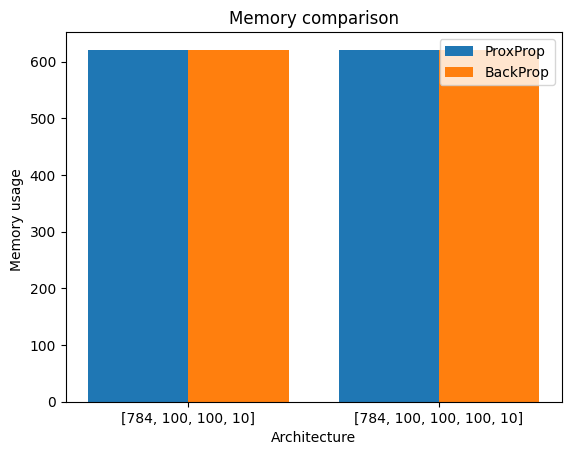

In [ ]:
# ### Your code goes here ###

import matplotlib.pyplot as plt
X_axis = np.arange(2)

num_layers = ["[784, 100, 100, 10]", "[784, 100, 100, 100, 10]"]
# mem-usage[0][0] is for first architecture, mem-usage[7][0] for second because I'm running 7 experiments on each
plt.bar(X_axis - 0.2, (memP_usage[0][0], memP_usage[7][0]), width = 0.4, label = "ProxProp")
plt.bar(X_axis + 0.2, (memB_usage[0][0], memB_usage[7][0]), width = 0.4, label = "BackProp")
plt.xticks(X_axis, num_layers)
plt.xlabel("Architecture")
plt.ylabel("Memory usage ")
plt.title("Memory comparison")
plt.legend()
plt.show()



###########################

In [ ]:
%load_ext memory_profiler

More exact measure of memory usage:

In [42]:
%memit 
network = ProxProp([784, 100, 100, 10])
network.SGD(
    (x_train, y_train),
    epochs=3,
    mini_batch_size=100,
    eta=3.0,
    test_data=(x_test, y_test),
)

peak memory: 610.09 MiB, increment: 0.00 MiB
Epoch: 0, Accuracy: 0.0764, Loss: 17.44714783881463
Epoch: 1, Accuracy: 0.8836, Loss: 0.7906261530051606
Epoch: 2, Accuracy: 0.9175, Loss: 0.40340309237736616
Epoch: 3, Accuracy: 0.9287, Loss: 0.32441118277754677


In [43]:
%memit 
network = Network([784, 100, 100, 10])
network.SGD(
    (x_train, y_train),
    epochs=3,
    mini_batch_size=100,
    eta=3.0,
    test_data=(x_test, y_test),
)

peak memory: 614.04 MiB, increment: 0.00 MiB
Epoch: 0, Accuracy: 0.5836, Loss: 5.511360761437687
Epoch: 1, Accuracy: 0.6868, Loss: 4.174699613837328
Epoch: 2, Accuracy: 0.7076, Loss: 3.694690852578777


Memory usage for both networks is similar, for ProxProp it's slightly better but the differences are not big. Hence it seems like ProxProp is very good.